In [1]:
%%time
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import transform

from shapely.geometry import Point, Polygon
import datetime

from io import StringIO
from pathlib import Path, PureWindowsPath
import os
import sys
from functools import partial

# Import custom functions from `scripts` folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from scripts.clean_tweets import geometrize_tweets, convert_shapefile_crs, find_frequencies
from scripts.home_location import assign_home_location
from scripts.summary_stats import summary_stats

np.random.seed(42)
pd.set_option('display.max_columns', 999)
data_path = Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Datasets/")
shape_path = Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Shared 228 Sydney Folder/SA2 Shapefiles/")

dv_analysis_path =  Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Shared 228 Sydney Folder/AU Work/MasterTypologyFolder")
sa2_w_dv = pd.read_csv(dv_analysis_path/'dummies_t3_corridor.csv')

Wall time: 867 ms


In [2]:
# read twitter data from 2012-2016 respectively
au12 = pd.read_csv(data_path/'au_twt2012.csv')
au13 = pd.read_csv(data_path/'au_twt2013.csv')
au14 = pd.read_csv(data_path/'au_twt2014.csv')
au15 = pd.read_csv(data_path/'au_twt2015.csv')
au16 = pd.read_csv(data_path/'au_twt2016.csv')

In [3]:
# Convert to GeoDataFrame based on lat/lon
au12 = geometrize_tweets(au12)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [4]:
au13 = geometrize_tweets(au13)

In [5]:
au14 = geometrize_tweets(au14)

In [6]:
au15 = geometrize_tweets(au15)

In [7]:
au16 = geometrize_tweets(au16)

In [8]:
# Read Australia SA2 shapefiles sa2_ucl
syd_ucl_sa2 = gpd.read_file(shape_path/'sa2_ucl.dbf')
# We also need to change the crs 
syd_ucl_sa2.crs = {'init': 'epsg:4326'}
# change the sa2_main16 ID to int
syd_ucl_sa2['SA2_MAIN16'] = syd_ucl_sa2['SA2_MAIN16'].astype(int)
# do the same for the case study area DVs
sa2_w_dv['SA2_MAIN16'] = sa2_w_dv['SA2_MAIN16'].astype(int)
# merge the two dataframes
syd_ucl_sa2 = pd.merge(syd_ucl_sa2, sa2_w_dv, how='left', on='SA2_MAIN16')
#drop variables
syd_ucl_sa2.drop('Unnamed: 0',axis=1,inplace=True)

In [9]:
syd_ucl_sa2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 265 entries, 0 to 264
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SA2_MAIN16  265 non-null    int32   
 1   SA2_5DIG16  265 non-null    object  
 2   SA2_NAME16  265 non-null    object  
 3   SA3_CODE16  265 non-null    object  
 4   SA3_NAME16  265 non-null    object  
 5   SA4_CODE16  265 non-null    object  
 6   SA4_NAME16  265 non-null    object  
 7   GCC_CODE16  265 non-null    object  
 8   GCC_NAME16  265 non-null    object  
 9   STE_CODE16  265 non-null    object  
 10  STE_NAME16  265 non-null    object  
 11  AREASQKM16  265 non-null    float64 
 12  geometry    265 non-null    geometry
 13  red_wat_dv  265 non-null    int64   
 14  marrick_dv  265 non-null    int64   
 15  t3_corr_dv  265 non-null    int64   
dtypes: float64(1), geometry(1), int32(1), int64(3), object(10)
memory usage: 34.2+ KB


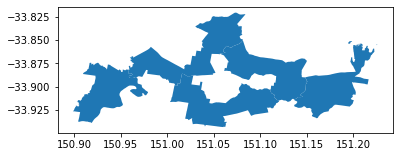

In [10]:
# let's isolate the sa2s that make up our case study areas of Redfern/Waterloo, Merrickville and Maroubra
t3_corr_gdf = syd_ucl_sa2[(syd_ucl_sa2.t3_corr_dv  ==1)]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
t3_corr_simple = t3_corr_gdf[['SA2_MAIN16','geometry', "SA4_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
t3_corr_sgdf=t3_corr_simple.dissolve(by="SA4_NAME16")
t3_corr_sgdf.plot()

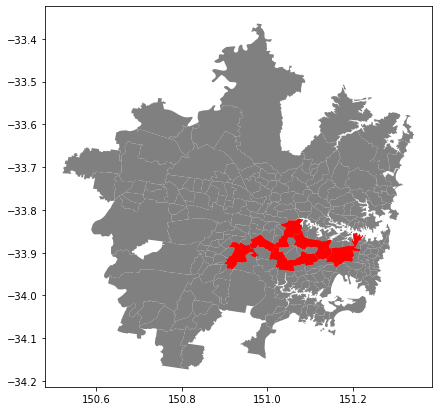

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
syd_ucl_sa2.plot(ax=ax, color='gray')
t3_corr_sgdf.plot(ax=ax, color='red')

## Assign tracts to tweets 
We are interested in two features:

   1. Whether or not a tweet is generated from our case study areas.
   1. Whether or not a tweet is within 0.5 miles of our case study areas

#### Finally, Lakemba

In [12]:
# Compute a spatial join between tweets and redfern/waterloo
au12_t3_cs = gpd.sjoin(au12, t3_corr_sgdf, how='left', op='intersects')
au13_t3_cs = gpd.sjoin(au13, t3_corr_sgdf, how='left', op='intersects')
au14_t3_cs = gpd.sjoin(au14, t3_corr_sgdf, how='left', op='intersects')
au15_t3_cs = gpd.sjoin(au15, t3_corr_sgdf, how='left', op='intersects')
au16_t3_cs = gpd.sjoin(au16, t3_corr_sgdf, how='left', op='intersects')

In [13]:
# If the tweet point lies in the tract geometry, `br_diss` is not null.
au12['t3_corr'] = ~au12_t3_cs['SA2_MAIN16'].isnull()
au13['t3_corr'] = ~au13_t3_cs['SA2_MAIN16'].isnull()
au14['t3_corr'] = ~au13_t3_cs['SA2_MAIN16'].isnull()
au15['t3_corr'] = ~au13_t3_cs['SA2_MAIN16'].isnull()
au16['t3_corr'] = ~au13_t3_cs['SA2_MAIN16'].isnull()

In [14]:
print(f"{au12['t3_corr'].sum()} of {len(au12)} 2012 tweets are from the Sydnenham-Bankstown Corridor")
print(f"{au13['t3_corr'].sum()} of {len(au13)} 2013 tweets are from the Sydnenham-Bankstown Corridor")
print(f"{au14['t3_corr'].sum()} of {len(au14)} 2014 tweets are from the Sydnenham-Bankstown Corridor")
print(f"{au15['t3_corr'].sum()} of {len(au15)} 2015 tweets are from the Sydnenham-Bankstown Corridor")
print(f"{au16['t3_corr'].sum()} of {len(au16)} 2016 tweets are from the Sydnenham-Bankstown Corridor")

199349 of 720158 2012 tweets are from the Sydnenham-Bankstown Corridor
591475 of 2160422 2013 tweets are from the Sydnenham-Bankstown Corridor
556832 of 2020287 2014 tweets are from the Sydnenham-Bankstown Corridor
284944 of 1031142 2015 tweets are from the Sydnenham-Bankstown Corridor
432886 of 1563682 2016 tweets are from the Sydnenham-Bankstown Corridor


# 2. Capturing distance from Sydnenham-Bankstown Corridor

Our next objective is to find tweets within 0.5 miles of RSydnenham-Bankstown Corridor. Instead of creating a buffer around Redfern/Waterloo, we can instead create a 0.5 mile buffer around each tweet's location, then find all tweets that overlap with the geometry of Sydnenham-Bankstown Corridor. The leftmost picture below illustrates this approach; we can consider the square to be the geometry of Redfern/Waterloo, and the circle to be the geometry of a single tweet.

Each degree of latitude is approximately 69 miles apart. For longitude to miles, at a given latitude, the conversion is as follows [source](https://gis.stackexchange.com/questions/142326/calculating-longitude-length-in-miles):

1 degree of longitude = cosine(latitude in decimal) * length of degree (miles) at equator

Then we compute:

In [15]:
# -33.9 is roughly the median latitude of Sydnenham-Bankstown Corridor
print(np.cos(-33.875) * 69.172)
print(.5/53.6765)

-53.676517723195055
0.009315063389006362


1 degree of latitude is 69 miles, and 1 degree of longitude is 57.1594 miles. This means that 0.5 miles is represented by $\frac{0.5}{69} \approx 0.007246$ degrees of latitude and $\frac{0.5}{57.1594} \approx .009315$ degrees of longitude. A roughly 0.5 mile buffer can be established by creating a buffer of ~0.008 degrees around each tweet.

In [16]:
BUFFER = 0.009

# Build dataframe containing buffer around each tweet
au12_buffer, au13_buffer, au14_buffer, au15_buffer, au16_buffer = au12.copy(), au13.copy(), au14.copy(), au15.copy(), au16.copy()
au12_buffer['geometry'] = au12_buffer.buffer(BUFFER)
au13_buffer['geometry'] = au13_buffer.buffer(BUFFER)
au14_buffer['geometry'] = au14_buffer.buffer(BUFFER)
au15_buffer['geometry'] = au15_buffer.buffer(BUFFER)
au16_buffer['geometry'] = au16_buffer.buffer(BUFFER)

### Capturing distance from Redfern/Waterloo

In [17]:
# Compute a spatial join between tweets and redfern/waterloo + buffer
au12_bufjoin_t3 = gpd.sjoin(au12_buffer, t3_corr_sgdf, how='left', op='intersects')

In [ ]:
au13_bufjoin_t3 = gpd.sjoin(au13_buffer, t3_corr_sgdf, how='left', op='intersects')

In [ ]:
au14_bufjoin_t3 = gpd.sjoin(au14_buffer, t3_corr_sgdf, how='left', op='intersects')
au15_bufjoin_t3 = gpd.sjoin(au15_buffer, t3_corr_sgdf, how='left', op='intersects')

In [ ]:
au16_bufjoin_t3 = gpd.sjoin(au16_buffer, t3_corr_sgdf, how='left', op='intersects')

In [ ]:
# If the tweet buffer intersects the tract geometry, `br_diss` is not null.
au12['buffer'] = ~au12_bufjoin_lk['SA2_MAIN16'].isnull()
au13['buffer'] = ~au13_bufjoin_lk['SA2_MAIN16'].isnull()
au14['buffer'] = ~au14_bufjoin_lk['SA2_MAIN16'].isnull()
au15['buffer'] = ~au15_bufjoin_lk['SA2_MAIN16'].isnull()
au16['buffer'] = ~au16_bufjoin_lk['SA2_MAIN16'].isnull()

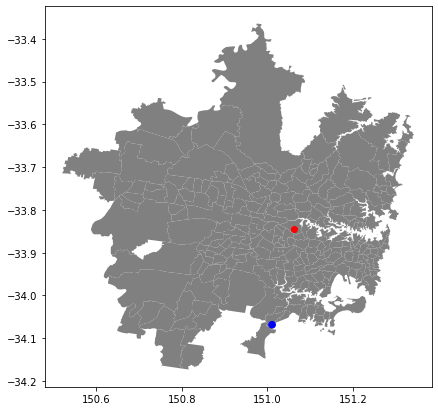

In [22]:
# Visualize one expanded tweet (blue), one regular tweet (red):
fig, ax = plt.subplots(figsize=(10, 7))
syd_ucl_sa2.plot(ax=ax, color='gray')
au13_buffer.sample(n=1).plot(ax=ax, color='blue')
au13.sample(n=1).plot(ax=ax, color='red');

In [23]:
print(f"{(au12['buffer'] & ~au12['lakemba']).sum()} of {len(au12)} 2012 tweets are from the buffer")
print(f"{(au13['buffer'] & ~au13['lakemba']).sum()} of {len(au13)} 2013 tweets are from the buffer")
print(f"{(au14['buffer'] & ~au14['lakemba']).sum()} of {len(au14)} 2014 tweets are from the buffer")
print(f"{(au15['buffer'] & ~au15['lakemba']).sum()} of {len(au15)} 2015 tweets are from the buffer")
print(f"{(au16['buffer'] & ~au16['lakemba']).sum()} of {len(au16)} 2016 tweets are from the buffer")

1445 of 720158 2012 tweets are from the buffer
10032 of 2160422 2013 tweets are from the buffer
27981 of 2020287 2014 tweets are from the buffer
5812 of 1031142 2015 tweets are from the buffer
6574 of 1563682 2016 tweets are from the buffer


# Analysis of derogatory words for Aboriginal people frequencies

We first observe all tweets (regardless of timestamp). For , to avoid any overlap with other words, we check for two patterns:


We also make our analysis case-insensitive.

In [30]:
print('{} of {} tweets sent from Redfern/Waterloo in 2012 contain "lakemba"'.format(
    *find_frequencies(au12.loc[au12['lakemba'], 'text'], r'lakemba')))

print('{} of {} tweets sent from Redfern/Waterloo in 2013 contain "lakemba"'.format(
    *find_frequencies(au13.loc[au13['lakemba'], 'text'], r'lakemba')))

print('{} of {} tweets sent from Redfern/Waterloo in 2014 contain "lakemba"'.format(
    *find_frequencies(au14.loc[au14['lakemba'], 'text'], r'lakemba')))

print('{} of {} tweets sent from Redfern/Waterloo in 2015 contain "lakemba"'.format(
    *find_frequencies(au15.loc[au15['lakemba'], 'text'], r'lakemba')))

print('{} of {} tweets sent from Redfern/Waterloo in 2016 contain "lakemba"'.format(
    *find_frequencies(au16.loc[au16['lakemba'], 'text'], r'lakemba')))

60 of 1064 tweets sent from Redfern/Waterloo in 2012 contain "lakemba"
93 of 2804 tweets sent from Redfern/Waterloo in 2013 contain "lakemba"
0 of 2558 tweets sent from Redfern/Waterloo in 2014 contain "lakemba"
0 of 1275 tweets sent from Redfern/Waterloo in 2015 contain "lakemba"
0 of 2175 tweets sent from Redfern/Waterloo in 2016 contain "lakemba"


In [25]:
# All tweets sent from Redfern/Waterloo
# print('{} of {} tweets sent from Redfern/Waterloo in 2012 contain "abo"'.format(
#     *find_frequencies(au12.loc[au12['redwat'], 'text'], r'abo')))

# print('{} of {} tweets sent from Redfern/Waterloo in 2012 contain "abbo "'.format(
#     *find_frequencies(au12.loc[au12['redwat'], 'text'], r'abbo')))

# print('{} of {} tweets sent from Redfern/Waterloo in 2012 contain "boong"'.format(
#     *find_frequencies(au12.loc[au12['redwat'], 'text'], r'boong')))

# print('{} of {} tweets sent from Redfern/Waterloo in 2012 contain "bung "'.format(
#     *find_frequencies(au12.loc[au12['redwat'], 'text'], r'bung')))

# print('{} of {} tweets sent from Redfern/Waterloo in 2012 contain "coon "'.format(
#     *find_frequencies(au12.loc[au12['redwat'], 'text'], r'coon')))

# print('{} of {} tweets sent from Redfern/Waterloo in 2012 contain "lubra"'.format(
#     *find_frequencies(au12.loc[au12['redwat'], 'text'], r'lubra')))

# print('{} of {} tweets sent from Redfern/Waterloo in 2012 contain "gin "'.format(
#     *find_frequencies(au12.loc[au12['redwat'], 'text'], r'gin')))



In [24]:
# Add hour for future analysis
au12['hour'] = pd.to_datetime(au12['created_at'] // 1000, unit='s').dt.hour
au13['hour'] = pd.to_datetime(au13['created_at'] // 1000, unit='s').dt.hour
au14['hour'] = pd.to_datetime(au14['created_at'] // 1000, unit='s').dt.hour
au15['hour'] = pd.to_datetime(au15['created_at'] // 1000, unit='s').dt.hour
au16['hour'] = pd.to_datetime(au16['created_at'] // 1000, unit='s').dt.hour